## Run if using Google Colab

In [2]:
!pip install pyvis
!pip install geopy

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Cours 3A/Projet 3A/Challenge Alstom - IA PAU'

/content/drive/MyDrive/Cours 3A/Projet 3A/Challenge Alstom - IA PAU


## Imports

In [1]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import random
from itertools import chain
import geopy.distance
import numpy as np

## Network plan

In [2]:
df_network_plan = pd.read_csv('plan du métro.csv')
df_network_plan.info()
df_network_plan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB


,de Ligne,de Station,vers Ligne,vers Station
0,1,Charles de Gaulle - Étoile,2,Charles de Gaulle - Étoile
1,1,Charles de Gaulle - Étoile,6,Charles de Gaulle - Étoile
2,1,Franklin D. Roosevelt,9,Franklin D. Roosevelt
3,1,Champs-Élysées - Clemenceau,13,Champs-Élysées - Clemenceau
4,1,Concorde,8,Concorde


In [3]:
#removing inter-station where target corresponds to a tramway station
df_network_plan = df_network_plan[~df_network_plan['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

In [4]:
print(set(df_network_plan['vers Ligne'].unique()) == set(df_network_plan['de Ligne'].unique()))

True


In [5]:
print(set(df_network_plan['vers Station'].unique()) == set(df_network_plan['de Station'].unique()))

True


In [7]:
df_position = pd.read_csv('position gps des stations de métro.csv')
df_position.info()
print(df_position.head())

#Removing Malsesherbes RER Station
df_position = df_position.drop([151])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  386 non-null    object
 1   GPS      386 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB
      Station                                    GPS
0   Boucicaut   48.84109405724891, 2.287945766487378
1      Bourse  48.86865415183625, 2.3413760511435733
2  Bir-Hakeim  48.85394260621378, 2.2893345327788075
3   Argentine  48.87533684211653, 2.2901275088247015
4   Daumesnil  48.83954964556868, 2.3957032894363937


In [8]:
network_stations = {station : {} for station in df_network_plan['de Station'].unique()}
reverse_network_stations = {}

# unique (station, line) couples that we're using as nodes in our graph
df_nodes = df_network_plan.groupby(['de Station','de Ligne']).size().reset_index().rename(columns={0:'count'})

count=0
for node in df_nodes.values:

  network_stations[node[0]].update({node[1] : count})
  reverse_network_stations.update({count : {'title' : node[0], 'group' :node[1]}})
  count+=1

In [9]:
unspecified_loc_nodes = []
for station, station_lines in network_stations.items():
  df_coords = df_position[df_position['Station'] == station]
  if not df_coords.empty:
    complete_gps = []
    if len(station_lines.values()) - len(df_coords['GPS'].values) > 0:
      for _ in range(len(station_lines.values()) - len(df_coords['GPS'].values)):
        complete_gps.append(random.choice(df_coords['GPS'].values))

    for coord, node_station in zip([*df_coords['GPS'].values, *complete_gps], station_lines.values()):
      lat, lon = coord.split(', ')
      lat, lon = float(lat), float(lon)
      reverse_network_stations[node_station].update({'lon':lon, 'lat':lat})
  else:
    unspecified_loc_nodes = [*unspecified_loc_nodes, *station_lines.values()]

In [10]:
edges = []
for edge in df_network_plan.values:
  edges.append((network_stations[edge[1]][edge[0]], network_stations[edge[3]][edge[2]]))

In [11]:
def get_node_neighbors(G, node, distance=1):
  if distance == 1:
    neighbors = list(G.neighbors(node))
    return neighbors
  else:
    neighbors = list(G.neighbors(node))
    total_neighbors = [neighbors.copy()]
    for neighbor in neighbors:
      total_neighbors.append(get_node_neighbors(G, neighbor, distance-1))
    total_neighbors = list(chain(*total_neighbors))
    return list(set(total_neighbors))
    # return list(chain(*total_neighbors))

In [12]:
network_graph = nx.Graph()
network_graph.add_edges_from(edges)
nx.set_node_attributes(network_graph, reverse_network_stations)

In [13]:
min_dist = 3
max_dist = 3
unspecified_loc_nodes_pos = {}
for node_station in unspecified_loc_nodes:
  mean_lat, mean_lon = [], []
  for dist in range(min_dist,max_dist+1):
    for neighbor in get_node_neighbors(network_graph, node_station, distance=dist):

      lon = reverse_network_stations[neighbor].get('lon')
      lat = reverse_network_stations[neighbor].get('lat')
      if lon is not None and lat is not None:
        mean_lat.append(lat)
        mean_lon.append(lon)

    if len(mean_lat) > 0 and len(mean_lon) > 0:
      unspecified_loc_nodes_pos.update({node_station : {'lon' : sum(mean_lon)/len(mean_lon), 'lat': sum(mean_lat)/len(mean_lat)}})
      break
    else:
      print(node_station)
      continue
nx.set_node_attributes(network_graph, unspecified_loc_nodes_pos)

## Adding edge weight based on distance between stations

In [14]:
for edge in network_graph.edges:
  start_node = network_graph.nodes[edge[0]]
  end_node = network_graph.nodes[edge[1]]
  distance = geopy.distance.geodesic((start_node['lat'], start_node['lon']), (end_node['lat'], end_node['lon'])).km
  network_graph.edges[edge]['inv_dist_km'] = 1/distance if distance != 0 else 1.0

## Network visualization

### With `pyvis`



In [15]:
net_viz = Network()
net_viz.from_nx(network_graph)
net_viz.save_graph('viz/network_graph_test.html')

### Using `networkx` API

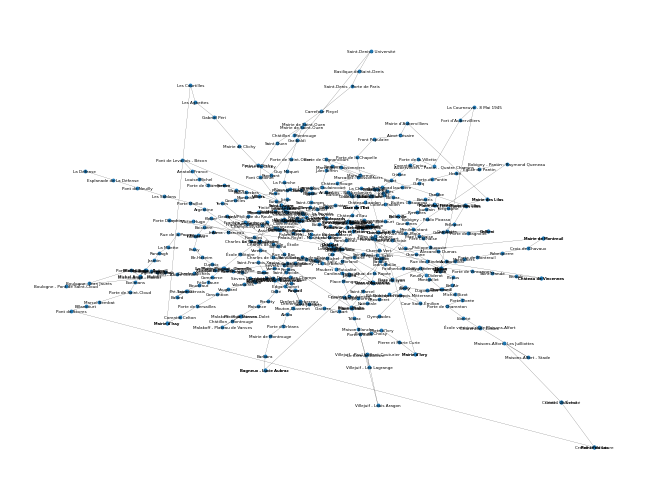

In [17]:
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in network_graph.nodes.items()}

nx.draw(network_graph, node_size=3, width=0.1, pos=pos, labels=nx.get_node_attributes(network_graph, 'title'), font_size=3)
#

## Flow for each path

In [18]:
df_flow = pd.read_csv('passagers.csv')
df_flow.info()
df_flow.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


,de,vers,nombre
0,La Défense,Esplanade de La Défense,7
1,La Défense,Pont de Neuilly,5
2,La Défense,Les Sablons,6
3,La Défense,Porte Maillot,6
4,La Défense,Argentine,5


In [20]:
def get_best_path(network_stations, start_station, end_station):
  lb_path_weight = 0
  for start_node in network_stations[start_station].values():
    for end_node in network_stations[end_station].values():
      current_path = nx.dijkstra_path(network_graph, start_node, end_node, weight='inv_dist_km')
      current_path_weight = sum([network_graph.edges[edge]['inv_dist_km'] for edge in zip(current_path[:-1], current_path[1:])])
      if current_path_weight > lb_path_weight:
        lb_path_weight = current_path_weight
        best_path = current_path
  return best_path

path_idx = np.random.randint(0, len(df_flow))
test_path = df_flow.iloc[path_idx]
print(test_path)
start_station = test_path['de']
end_station = test_path['vers']
flow = test_path['nombre']

best_path = get_best_path(network_stations, start_station, end_station)
print(" ->\n".join([f'{reverse_network_stations[node]["title"]} ({reverse_network_stations[node]["group"]})' for node in best_path]))

de                   Gare de l'Est
vers      Basilique de Saint-Denis
nombre                           2
Name: 24151, dtype: object
Gare de l'Est (7) ->
Poissonnière (7) ->
Cadet (7) ->
Le Peletier (7) ->
Chaussée d'Antin - La Fayette (7) ->
Opéra (7) ->
Opéra (3) ->
Havre - Caumartin (3) ->
Saint-Lazare (3) ->
Saint-Lazare (14) ->
Pont Cardinet (14) ->
Porte de Clichy (14) ->
Saint-Ouen (14) ->
Mairie de Saint-Ouen (14) ->
Mairie de Saint-Ouen (13) ->
Carrefour Pleyel (13) ->
Saint-Denis - Porte de Paris (13) ->
Basilique de Saint-Denis (13)


In [21]:
def get_nodes_traffic(network_graph, df_flow):
  nodes_traffic = {node_idx : {'traffic' : 0} for node_idx in network_graph.nodes}
  for path_idx in range(len(df_flow)):
    path = df_flow.iloc[path_idx]
    start_station = path['de']
    end_station = path['vers']
    flow = path['nombre']
    best_path = get_best_path(network_stations, start_station, end_station)
    for node in best_path:
      nodes_traffic[node]['traffic'] += flow
  return nodes_traffic

nodes_traffic = get_nodes_traffic(network_graph, df_flow)
# nodes_traffic

In [27]:
total_trafic = sum([node['traffic'] for node in nodes_traffic.values()])
print(total_trafic)
normalized_nodes_traffic = {node_idx : {'traffic' : node['traffic']/total_trafic} for node_idx, node in nodes_traffic.items()}
# normalized_nodes_traffic

8122106


In [28]:
nx.set_node_attributes(network_graph, normalized_nodes_traffic)

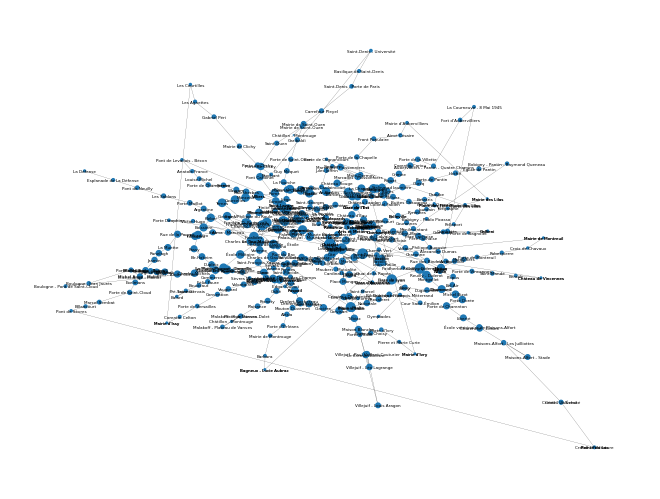

In [30]:
node_size = [5000*node['traffic'] for node in network_graph.nodes.values()]
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in network_graph.nodes.items()}

nx.draw(network_graph, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(network_graph, 'title'), font_size=3)